Goal of this notebook to test several classifiers on the data set with different features

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

Let's read the data from csv file

In [2]:
sms = pd.read_csv('spam.csv', encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message"

In [3]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

Let's look into our data

In [4]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Intresting that "Sorry, I'll call later" appears only 30 times here =)

Now let's create new feature "message length" and plot it to see if it's of any interest

In [5]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<ipython-input-6-88364cd06415>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-bright')


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

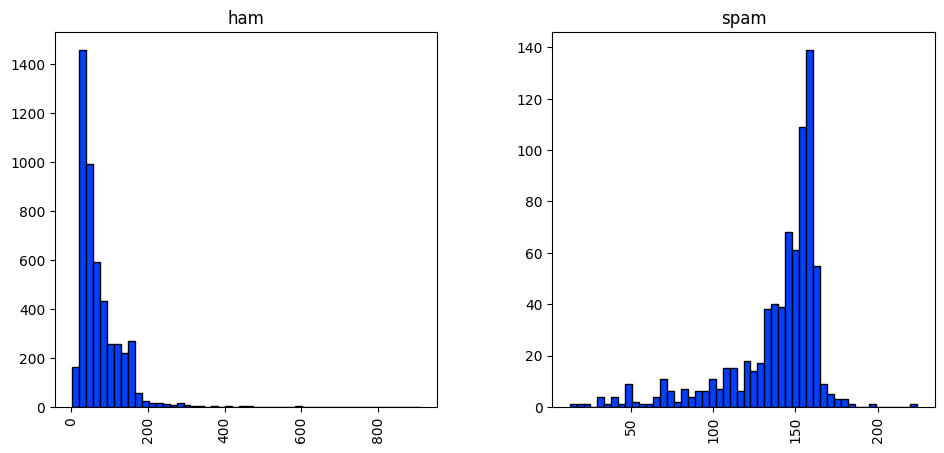

In [6]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

Looks like the lengthy is the message, more likely it is a spam. Let's not forget this

### Text processing and vectorizing our meddages

Let's create new data frame. We'll need a copy later on

In [7]:
text_feat = sms['message'].copy()

Now define our tex precessing function. It will remove any punctuation and stopwords aswell.

In [8]:
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

In [10]:
text_feat = text_feat.apply(text_process)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [11]:
vectorizer = TfidfVectorizer()

In [12]:
features = vectorizer.fit_transform(text_feat)

###  Classifiers and predictions

First of all let's split our features to test and train set

In [13]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

Now let's import bunch of classifiers, initialize them and make a dictionary to itereate through

In [14]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

In [15]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Let's make functions to fit our classifiers and make predictions

In [16]:
def train_classifier(clf, feature_train, labels_train):
    clf.fit(feature_train, labels_train)

In [17]:
def predict_labels(clf, features):
    return (clf.predict(features))

Now iterate through classifiers and save the results

In [18]:
pred_scores = []
pred_dict={}
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))
    pred_dict[k]=[accuracy_score(labels_test,pred)]

In [19]:
df = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score'])
df

,Score
SVC,0.985048
KN,0.944976
NB,0.989833
DT,0.969498
LR,0.959928
RF,0.980263
AdaBoost,0.980861
BgC,0.974282
ETC,0.981459


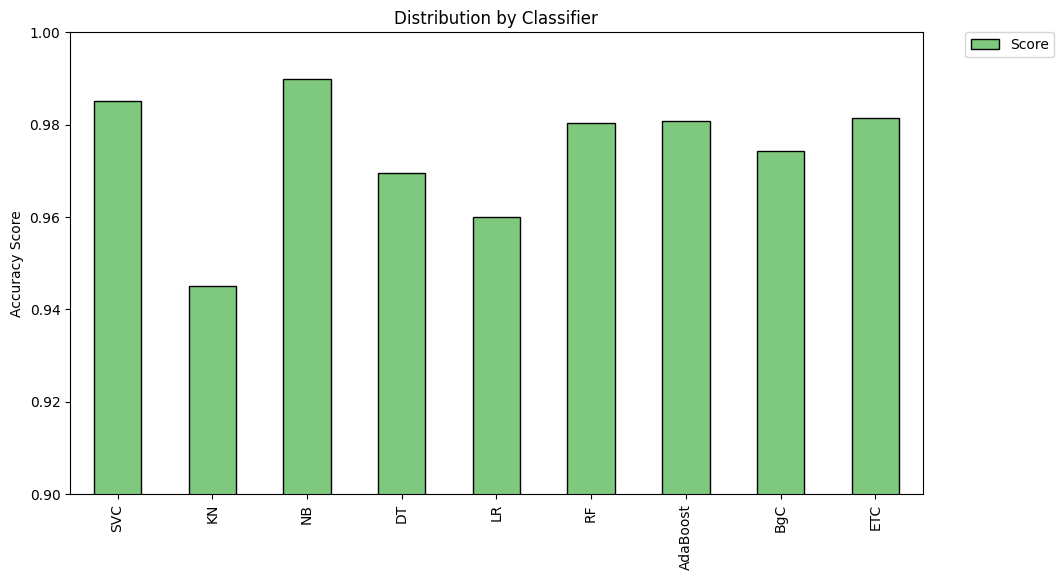

In [20]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like ensemble classifiers are not doing as good as expected.

### Stemmer

Define our stemmer function

In [21]:
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

In [22]:
text_feat = text_feat.apply(stemmer)

In [23]:
features = vectorizer.fit_transform(text_feat)

In [24]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [25]:
pred_dict={}
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_dict[k]=[accuracy_score(labels_test,pred)]

In [26]:
df2 = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score2'])
df = pd.concat([df,df2],axis=1)
df

,Score,Score2
SVC,0.985048,0.984450
KN,0.944976,0.943182
NB,0.989833,0.989833
DT,0.969498,0.961124
LR,0.959928,0.955742
RF,0.980263,0.978469
AdaBoost,0.980861,0.975478
BgC,0.974282,0.971292
ETC,0.981459,0.979665


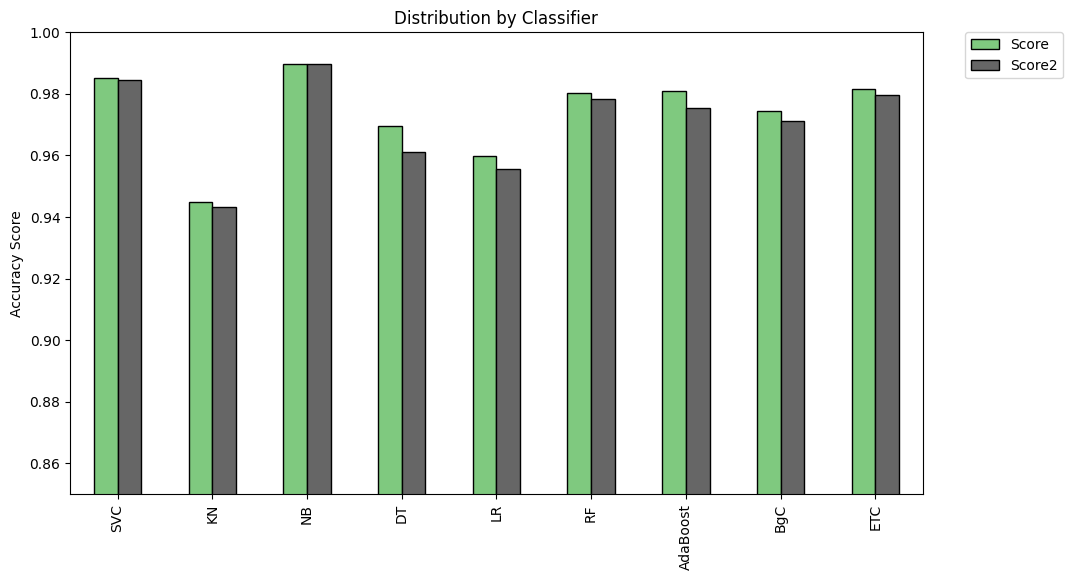

In [27]:
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like mostly the same . Ensemble classifiers doing a little bit better, NB still got the lead.

### Voting classifier

We are using ensemble algorithms here, but what about ensemble of ensembles? Will it beat NB?

In [28]:
from sklearn.ensemble import VotingClassifier

In [29]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [30]:
eclf.fit(features_train,labels_train)

VotingClassifier(estimators=[('BgC',
                              BaggingClassifier(n_estimators=9,
                                                random_state=111)),
                             ('ETC',
                              ExtraTreesClassifier(n_estimators=9,
                                                   random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=31,
                                                     random_state=111)),
                             ('Ada',
                              AdaBoostClassifier(n_estimators=62,
                                                 random_state=111))],
                 voting='soft')

In [31]:
pred = eclf.predict(features_test)

In [32]:
print(accuracy_score(labels_test,pred))

0.9808612440191388


Better but nope.

### Final verdict - well tuned NaiveBayes is your friend in spam detection.